In [7]:
!pip install mtcnn

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from mtcnn import MTCNN
from cv2 import imread
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import cv2

import warnings
warnings.filterwarnings('ignore')

to detect face using mtcnn

for larger dataset

(904, 600, 3)


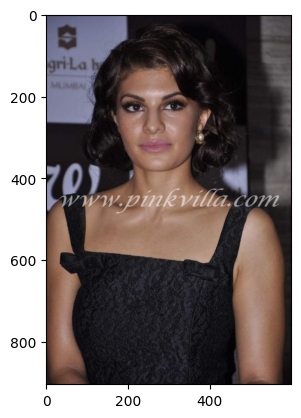

In [10]:
# load image from file using PIL
filename = '/content/drive/MyDrive/Colab Notebooks/train/Jacqueline_Fernandez/Jacqueline_Fernandez_10.jpg'
image = Image.open(filename)
# convert to RGB, if needed
image = image.convert('RGB')
# convert to array
pixels = np.asarray(image)
plt.imshow(pixels)
print(pixels.shape)

In [11]:
# create the face detector, using default weights
detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(pixels)

1/1 [==============================] - 0s 161ms/step


In [12]:
## Assuming that only 1 face is present
# extract the bounding box from the first face
x1, y1, width, height = results[0]['box']

# bug fix - Sometimes the library will return a negative pixel index
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height

In [13]:
# extract the face. this is like cropping the face from image
face = pixels[y1:y2, x1:x2]

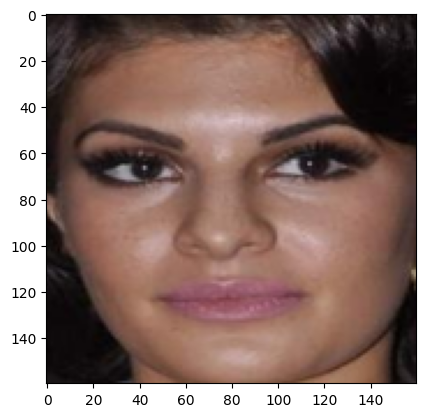

In [14]:
# resize pixels to the model size
image = Image.fromarray(face)
image = image.resize((160, 160))
face_array = np.asarray(image)
# Lets show the extracted face
plt.imshow(face_array)

In [15]:
# Function to extract a single face from a given photograph
def extract_face(filename=None, image_pixels=None, required_size=(160, 160)):
    if filename is not None:
        image = Image.open(filename)
        image = image.convert('RGB')
        pixels = np.asarray(image)
    elif image_pixels is not None:
        pixels = image_pixels
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    box_dimensions = (x1, y1, width, height)
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array, box_dimensions

1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 497ms/step


1/1 [==============================] - 0s 151ms/step


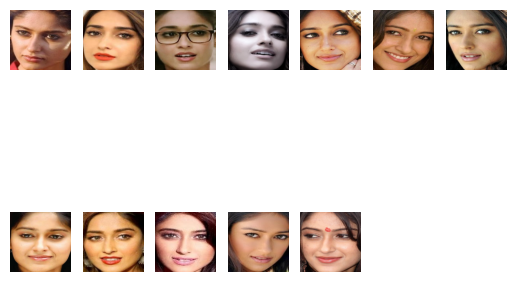

In [16]:
## Lets extract faces of elton john for example
image_path = '/content/drive/MyDrive/Colab Notebooks/train/Ileana'
files = os.listdir(image_path)
i=1
for filename in files:
    full_path = os.path.join(image_path, filename)
    face, _ = extract_face(filename=full_path)
    plt.subplot(2, 7, i)
    plt.axis('off')
    plt.imshow(face)
    i+=1
    if i>14:
        break

In [17]:
# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = []
    # enumerate files
    for filename in os.listdir(directory):
        # path
        path = os.path.join(directory,filename)
        # get face
        face, _ = extract_face(filename=path)
        # store
        faces.append(face)
    return faces

In [18]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = [], []
    for subdir in os.listdir(directory):
        path = os.path.join(directory, subdir)
        if not os.path.isdir(path):
            continue
        faces = load_faces(path)
        labels = [subdir for _ in range(len(faces))]
        print(f'Loaded {len(faces)} examples for class: {subdir}')
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [ ]:
# load train dataset
#../input/5-celebrity-faces-dataset/train/ben_afflek/httpcsvkmeuaeccjpg.jpg
X_train, y_train = load_dataset(r'/content/drive/MyDrive/Colab Notebooks/train')
print(X_train.shape, y_train.shape)

# load validation dataset
X_val, y_val = load_dataset(r'/content/drive/MyDrive/Colab Notebooks/val')
print(X_val.shape, y_val.shape)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 148ms/step
Loaded 12 examples for class: Sunny_Deol
1/1 [==============================] - 0s 146ms/step
Loaded 12 examples for class: Tabu
1/1 [==============================] - 1s 574ms/step
Loaded 12 examples for class: Sidharth_Malhotra
2/2 [==============================] - 0s 36ms/step
Loaded 13 examples for class: Sonam_Kapoor
1/1 [==============================] - 0s 192ms/step
Loaded 12 examples for class: Sara_Ali_Khan
1/1 [==============================] - 0s 172ms/step
Loaded 12 examples for class: Shraddha_Kapoor
1/1 [==============================] - 0s 152ms/step
Loaded 12 examples for class: Shilpa_Shetty
1/1 [==============================] - 0s 189ms/step
Loaded 12 examples for class: Saif_Ali_Khan
1/1 [==============================] - 0s 176ms/step
Loaded 12 examples for class: Sanjay_Dutt
1/1 [==============================] - 0s 169ms/step
Loaded 12 examples for class: Sal

## Face Embeddings
### FaceNet
FaceNet is a face recognition system developed in 2015 by researchers at Google that achieved then state-of-the-art results on a range of face recognition benchmark datasets. The FaceNet system can be used to extract high-quality features from faces, called face embeddings, that can then be used to train a face identification system.

The model is a deep convolutional neural network trained via a triplet loss function that encourages vectors for the same identity to become more similar (smaller distance), whereas vectors for different identities are expected to become less similar (larger distance). The focus on training a model to create embeddings directly (rather than extracting them from an intermediate layer of a model) was an important innovation in this work.

In [ ]:

from numpy import load
from numpy import asarray
from numpy import expand_dims
from numpy import savez_compressed
from numpy import reshape
from keras.models import load_model

In [ ]:
!pip install keras_facenet
from keras_facenet import FaceNet

In [ ]:
model=FaceNet()

In [ ]:
#Generalize the data and extract the embeddings
def extract_embeddings(model,face_pixels):
  face_pixels = face_pixels.astype('float32')  #convert the entire data to float32(base)
  #mean = face_pixels.mean()                    #evaluate the mean of the data
  #std  = face_pixels.std()                     #evaluate the standard deviation of the data
  #face_pixels = (face_pixels - mean)/std
  detections = model.extract(face_pixels, threshold=0.95)
  samples = expand_dims(face_pixels,axis=0)    #expand the dimension of data
  yhat = model.embeddings(samples)
  return yhat[0]


In [ ]:
#get the face embeddings
new_trainx = list()
for train_pixels in X_train:
  embeddings = extract_embeddings(model,train_pixels)
  new_trainx.append(embeddings)
new_trainx = np.asarray(new_trainx)             #convert the embeddings into numpy array
print(new_trainx.shape)

1/1 [==============================] - 0s 23ms/step


In [ ]:
# convert each face in the test set to an embedding
newTestX = []
for face_pixels in X_val:
    embedding = extract_embeddings(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

### Face Classification Steps
1. Vector Normalization
2. Label Encode the Targets
3. Use SVM model to train and predict

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

In [38]:
# Normalize input vectors - We need to normalize the face embeddings
in_encoder = Normalizer(norm='l2')
X_train = in_encoder.transform(new_trainx)
X_val = in_encoder.transform(newTestX)

In [39]:
# Label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_val = out_encoder.transform(y_val)
#pickle.dump(model, open('LabelEncoder.sav', 'wb'))

In [40]:
# fit model
svc_model = SVC(kernel='linear', probability=True)
svc_model.fit(X_train, y_train)
#pickle.dump(model, open('SVC.sav', 'wb'))

SVC(kernel='linear', probability=True)

In [41]:
# predict
yhat_train = svc_model.predict(X_train)
yhat_test = svc_model.predict(X_val)

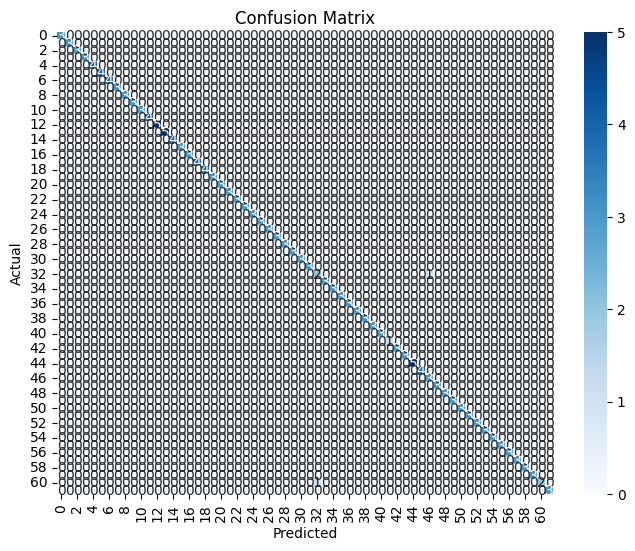

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you've already calculated predictions for your validation set
# Calculate the confusion matrix

cm = confusion_matrix(y_val, yhat_test)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# You can also write the confusion matrix to a file if needed
# with open("confusion_matrix.txt", "w") as file:
#     file.write("Confusion Matrix:\n")
#     file.write(str(cm))

In [42]:
X_train.shape

(770, 512)

In [50]:
from sklearn.metrics import accuracy_score

score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_val, yhat_test)

probability = svc_model.predict_proba(X_val)
confidence = max(probability[:, 1])  # Assuming you want the maximum confidence for the positive class

print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))
print('Confidence:', confidence)



Accuracy: train=99.870, test=98.990
Confidence: 0.26864867862155095


#### Model Deployment

In [44]:
## Load the trained LabelEncoder and SVM model
loaded_encoder = out_encoder
loaded_predictor = svc_model
loaded_facenet = FaceNet()

In [45]:
loaded_encoder.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [46]:
# Single Function capable to process input image and return the bounding box dimensions and the prediction
def face_recognize(image):
    ## Extract the face and bounding box dimensions from the image by using pretrained MTCNN model
    faces, box_dimensions = extract_face(image_pixels=image)
    X = np.asarray(faces)
    ## Get the Face Embeddings for the extracted face pixels and store as numpy array
    embedding = extract_embeddings(loaded_facenet, X)
    X = []
    X.append(embedding)
    X = np.asarray(X)
    ## Predict label for the face by using the pretrained models
    prediction = loaded_predictor.predict(X)
    predicted_label = loaded_encoder.inverse_transform([prediction])
    return predicted_label[0], box_dimensions

In [47]:
## Testing the model with the random image
filename = '/content/drive/MyDrive/Colab Notebooks/train/Karisma_Kapoor/Karisma_Kapoor_1.jpg'
image = Image.open(filename)
image = image.convert('RGB')
pixels = np.asarray(image)
face_recognize(pixels)

1/1 [==============================] - 0s 166ms/step


(6, (368, 146, 185, 260))

![](./ben_afflek_processed.gif)

In [53]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

In [54]:
# Normalize input vectors - We need to normalize the face embeddings
in_encoder = Normalizer(norm='l2')
X_train = in_encoder.transform(new_trainx)
X_val = in_encoder.transform(newTestX)

In [55]:
# Label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_val = out_encoder.transform(y_val)
#pickle.dump(model, open('LabelEncoder.sav', 'wb'))

In [56]:
#pickle.dump(model, open('SVC.sav', 'wb'))
k = 12  # Number of nearest neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=12)

In [57]:
yhat_train = knn_model.predict(X_train)
yhat_test = knn_model.predict(X_val)

In [58]:
X_train.shape

(770, 512)

In [59]:
from sklearn.metrics import accuracy_score

score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_val, yhat_test)

In [62]:

prob_train = knn_model.predict_proba(X_train)
prob_test = knn_model.predict_proba(X_val)
confidence_train = prob_train.max(axis=1)  # Maximum probability across all classes for each sample in the training set
confidence_test = prob_test.max(axis=1)  # Maximum probability across all classes for each sample in the test set

In [63]:
print('Accuracy: train=%.3f, test=%.3f' % (score_train * 100, score_test * 100))
print('Confidence: train=%.3f, test=%.3f' % (confidence_train.mean() * 100, confidence_test.mean() * 100))

Accuracy: train=98.571, test=98.485
Confidence: train=94.545, test=94.444


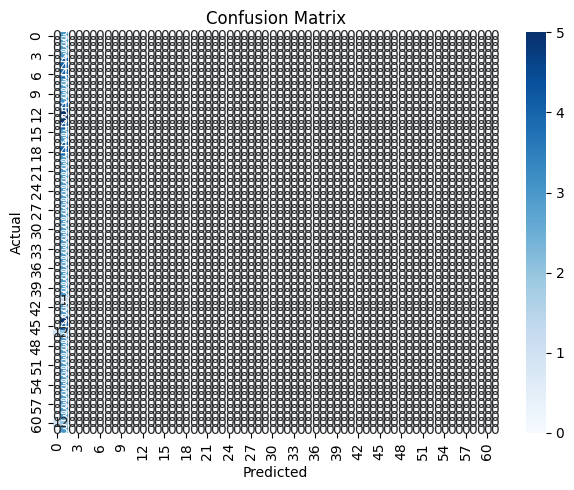

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the threshold for binary classification (e.g., 0.5)
threshold = 0.5

# Convert confidence values to binary predicted labels
y_pred_train = (confidence_train > threshold).astype(int)
y_pred_test = (confidence_test > threshold).astype(int)

# Calculate the confusion matrix for the training set
cm_train = confusion_matrix(y_train, y_pred_train)

# Calculate the confusion matrix for the validation set
cm_test = confusion_matrix(y_val, y_pred_test)

# Display the confusion matrices as heatmaps
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()


Accuracy: train=98.571, test=98.485
Confidence: train=94.545, test=94.444


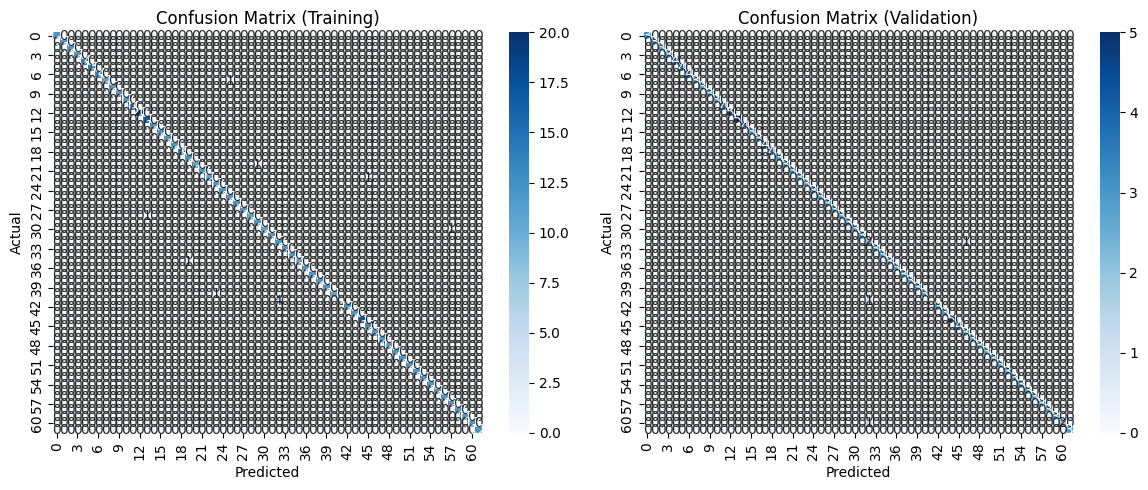

In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... (Previous code for data preprocessing and model training)

# Calculate accuracy scores
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_val, yhat_test)

# Calculate confidence values
prob_train = knn_model.predict_proba(X_train)
prob_test = knn_model.predict_proba(X_val)
confidence_train = prob_train.max(axis=1)
confidence_test = prob_test.max(axis=1)

# Display accuracy and confidence
print('Accuracy: train=%.3f, test=%.3f' % (score_train * 100, score_test * 100))
print('Confidence: train=%.3f, test=%.3f' % (confidence_train.mean() * 100, confidence_test.mean() * 100))

# Create confusion matrices
cm_train = confusion_matrix(y_train, yhat_train)
cm_test = confusion_matrix(y_val, yhat_test)

# Display confusion matrices as heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training)')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation)')

plt.tight_layout()
plt.show()


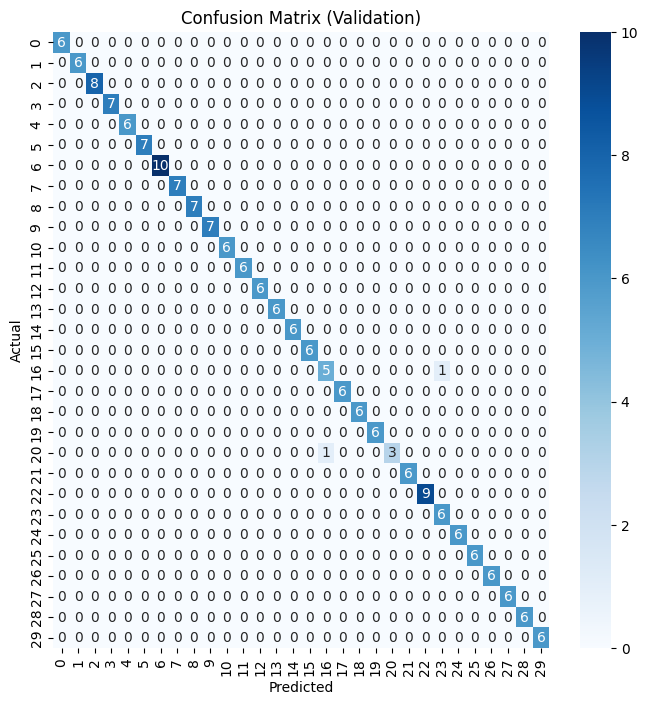

In [72]:
# Assuming cm_test is your original 60x60 confusion matrix
# Reduce it to a 30x30 confusion matrix by grouping every two classes into one

reduced_cm = np.zeros((30, 30), dtype=int)

for i in range(0, 60, 2):
    for j in range(0, 60, 2):
        reduced_cm[i//2, j//2] = cm_test[i:i+2, j:j+2].sum()

# Display the reduced confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(reduced_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation)')
plt.show()
